In [164]:
import numpy as np
import pandas as pd
import geopandas as gpd
idx = pd.IndexSlice
import xarray as xr

from shapely.geometry import Point

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from itertools import product

import sys
sys.path.append('../../funcs')
from taus import decorrelation_temporal_model, fit_coh_decay_model

from scipy.stats import linregress

In [197]:
def clean_snotel(df):
    for col in ['SWE', 'SNOWDEPTH', 'AVG AIR TEMP']: df[col] = df[col].astype(float)
    # convert inches to meters
    df['swe'] = df['SWE'] * 0.0254
    df['sd'] = df['SNOWDEPTH'] * 0.0254
    # convert F to C
    df['temp'] = (df['AVG AIR TEMP'] - 32) * 5/9
    df = df.drop(['SWE', 'SWE_units', 'SNOWDEPTH', 'SNOWDEPTH_units', 'AVG AIR TEMP', 'AVG AIR TEMP_units'], axis = 1)
    return df

In [230]:
dss = {fp.stem: xr.open_dataset(fp) for fp in sorted(list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*.nc')))}
df = pd.read_csv(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/data/snotel').joinpath('snotel_uavsar_diffs.csv'))
fig_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/figures/snotels')

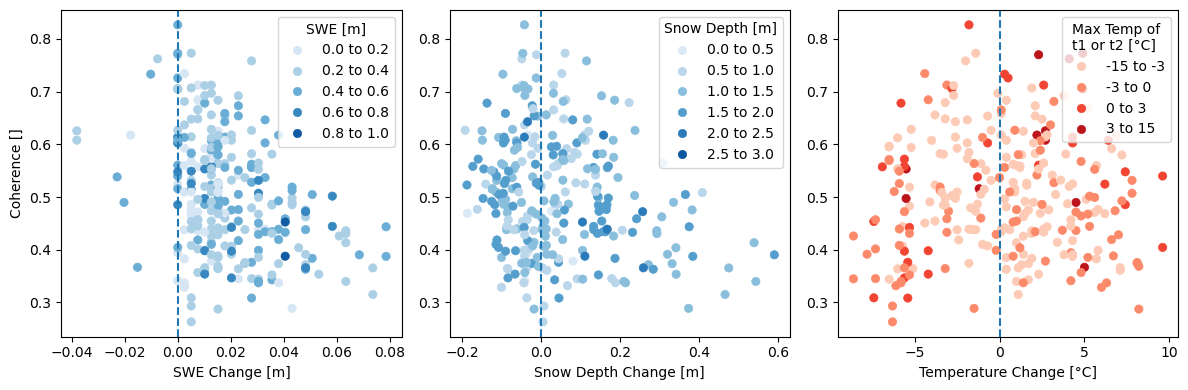

In [235]:
fig, axes= plt.subplots(1,3 , figsize = (12, 4))
# gs = axes[0, 1].get_gridspec()
# for ax in axes[1, :]: ax.remove()
# axbig = fig.add_subplot(gs[1, :])

data = df[df.days < 8].copy()#.loc[df.snotel.isin((df[df.days < 8].value_counts('snotel') > 20).index)]

ax= axes[0]
data['swe2_bins'] = pd.cut(data['swe_t2'], bins = [0, 0.2, 0.4, 0.6, 0.8, 1])
sns.scatterplot(x='swe_diff', y='cor', data=data, hue='swe2_bins', ec=None, legend=True, ax= ax, palette = 'Blues')
handles, labels = ax.get_legend_handles_labels()
labels = [' to'.join(l.replace('(','').replace(')','').replace(']','').replace('[]','').split(',')) for l in ax.get_legend_handles_labels()[1]]
ax.legend(handles, labels, title='SWE [m]')
# ax.set_xlim(-0.07, 0.1)
ax.axvline(0, linestyle = '--')
ax.set_xlabel('SWE Change [m]')

ax= axes[1]
data['sd_diff'] = data['sd_diff'] + np.random.random(len(data))/50
data['sd2_bins'] = pd.cut(data['sd_t2'], bins = [0, 0.5, 1, 1.5, 2, 2.5, 3])
sns.scatterplot(x='sd_diff', y='cor', data=data, hue='sd2_bins', ec=None, legend=True, ax = ax, palette = 'Blues')
handles, labels = ax.get_legend_handles_labels()
labels = [' to'.join(l.replace('(','').replace(')','').replace(']','').replace('[]','').split(',')) for l in ax.get_legend_handles_labels()[1]]
ax.legend(handles, labels, title='Snow Depth [m]')
# ax.set_xlim(-0.07, 0.1)
ax.axvline(0, linestyle = '--')
ax.set_xlabel('Snow Depth Change [m]')

ax= axes[2]
data['max_temp'] = np.max(data[['temp_t1','temp_t2']],axis= 1)
data['temp1_bins'] = pd.cut(data['max_temp'], bins = [-15, -3, 0, 3, 15])
sns.scatterplot(x='temp_diff', y='cor', data=data, hue='temp1_bins', ec=None, legend=True, ax = ax, palette = 'Reds')
handles, labels = ax.get_legend_handles_labels()
labels = [' to'.join(l.replace('(','').replace(')','').replace(']','').replace('[]','').split(',')) for l in ax.get_legend_handles_labels()[1]]
ax.legend(handles, labels, title='Max Temp of\nt1 or t2 [°C]')

# ax.set_xlim(-0.07, 0.1)
ax.axvline(0, linestyle = '--')
ax.set_xlabel('Temperature Change [°C]')

# ex_sntl = gpd.read_file('/Users/rdcrlzh1/Documents/uavsar-coherence/data/snotel/stlake/766:UT:SNTL.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS = "NO", parse_dates = True, index_col = 0)
# ex_sntl = ex_sntl.set_index(pd.to_datetime(ex_sntl['datetime']))
# x = ex_sntl.geometry.iloc[0].x
# y = ex_sntl.geometry.iloc[0].y
# ex_sntl = clean_snotel(ex_sntl)
# ex_sntl[['swe', 'sd']].plot(ax = axbig)
# ds = dss['stlake_full']['cor'].sel(pol = 'HH')
# axbig_r = axbig.twinx()

# for t1, t2 in product(ds.time1, ds.time2):
#     if (~ds.sel(time1 = t1, time2 = t2).isel(heading = 0).isnull()).sum() == 0: continue
#     tol = 0.00090009
#     mcor = ds.sel(time1 = t1, time2 = t2, x = slice(x - tol, x + tol), y = slice(y+tol, y-tol)).mean().values.ravel()[0]
#     t1, t2 = pd.to_datetime(t1.values.ravel()[0]), pd.to_datetime(t2.values.ravel()[0]) 
#     axbig_r.plot([t1, t2], [mcor, mcor], color = 'black', linewidth = 4)

# axbig.set_xlim('2020-10-01', '2021-06-01')
for ax in axes.ravel(): ax.set_ylabel('')
axes[0].set_ylabel('Coherence []')

plt.tight_layout()
plt.savefig(fig_dir.joinpath('snotel_summary.png'))

In [192]:
ex_sntl

,datetime,site,SWE,SWE_units,SNOWDEPTH,SNOWDEPTH_units,AVG AIR TEMP,AVG AIR TEMP_units,datasource,geometry
0,2019-10-01 08:00:00+00:00,766:UT:SNTL,0.0,in,0.0,in,34.52,degF,NRCS,POINT Z (-111.65852 40.56914 9177.00000)
1,2019-10-02 08:00:00+00:00,766:UT:SNTL,0.0,in,0.0,in,33.98,degF,NRCS,POINT Z (-111.65852 40.56914 9177.00000)
2,2019-10-03 08:00:00+00:00,766:UT:SNTL,0.0,in,0.0,in,46.58,degF,NRCS,POINT Z (-111.65852 40.56914 9177.00000)
3,2019-10-04 08:00:00+00:00,766:UT:SNTL,0.0,in,0.0,in,37.22,degF,NRCS,POINT Z (-111.65852 40.56914 9177.00000)
4,2019-10-05 08:00:00+00:00,766:UT:SNTL,0.1,in,1.0,in,34.52,degF,NRCS,POINT Z (-111.65852 40.56914 9177.00000)
...,...,...,...,...,...,...,...,...,...,...
970,2022-05-28 08:00:00+00:00,766:UT:SNTL,10.0,in,20.0,in,43.52,degF,NRCS,POINT Z (-111.65852 40.56914 9177.00000)
971,2022-05-29 08:00:00+00:00,766:UT:SNTL,9.4,in,19.0,in,32.0,degF,NRCS,POINT Z (-111.65852 40.56914 9177.00000)
972,2022-05-30 08:00:00+00:00,766:UT:SNTL,10.5,in,21.0,in,30.2,degF,NRCS,POINT Z (-111.65852 40.56914 9177.00000)
973,2022-05-31 08:00:00+00:00,766:UT:SNTL,10.9,in,23.0,in,33.98,degF,NRCS,POINT Z (-111.65852 40.56914 9177.00000)


In [22]:
df.groupby(pd.cut(df['swe_diff'], bins = 50)).cor.mean()

/var/folders/hn/hd92_2tj7rj8xghqt1qf0nhr2p1n49/T/ipykernel_39811/1984001651.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df['swe_diff'], bins = 50)).cor.mean()


swe_diff
(-0.384, -0.369]      0.316194
(-0.369, -0.355]           NaN
(-0.355, -0.341]           NaN
(-0.341, -0.326]      0.303154
(-0.326, -0.312]           NaN
(-0.312, -0.298]           NaN
(-0.298, -0.284]      0.317377
(-0.284, -0.269]      0.277825
(-0.269, -0.255]           NaN
(-0.255, -0.241]           NaN
(-0.241, -0.226]           NaN
(-0.226, -0.212]      0.268675
(-0.212, -0.198]           NaN
(-0.198, -0.184]           NaN
(-0.184, -0.169]           NaN
(-0.169, -0.155]           NaN
(-0.155, -0.141]           NaN
(-0.141, -0.127]           NaN
(-0.127, -0.112]           NaN
(-0.112, -0.098]           NaN
(-0.098, -0.0837]          NaN
(-0.0837, -0.0695]    0.666885
(-0.0695, -0.0552]    0.594622
(-0.0552, -0.0409]    0.563746
(-0.0409, -0.0267]    0.552453
(-0.0267, -0.0124]    0.484051
(-0.0124, 0.0019]     0.593252
(0.0019, 0.0162]      0.516973
(0.0162, 0.0304]      0.494615
(0.0304, 0.0447]      0.447072
(0.0447, 0.059]       0.419184
(0.059, 0.0733]       0.382328

Slope: -0.003560718228873549. p: 5.175002404775814e-07


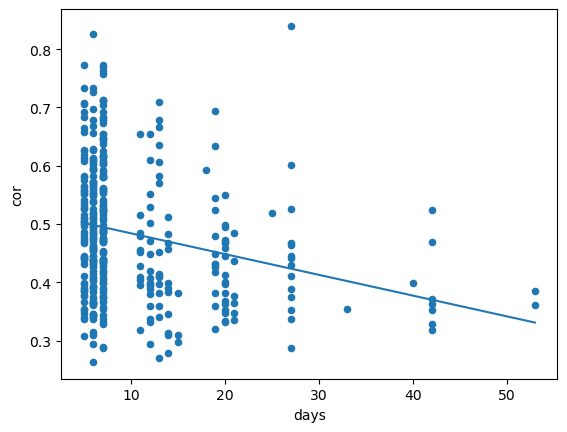

In [19]:
x_col = 'days'
sub = df[df.days < 100].dropna(subset = ['cor', x_col])

sub.plot.scatter(x = x_col, y = 'cor')

lm = linregress(x = sub[x_col], y = sub.cor)
xs = np.linspace(sub[x_col].min(), sub[x_col].max(), 100)
plt.plot(xs, lm.slope*xs+lm.intercept)
print(f'Slope: {lm.slope}. p: {lm.pvalue}')

<Axes: xlabel='tree_perc', ylabel='cor'>

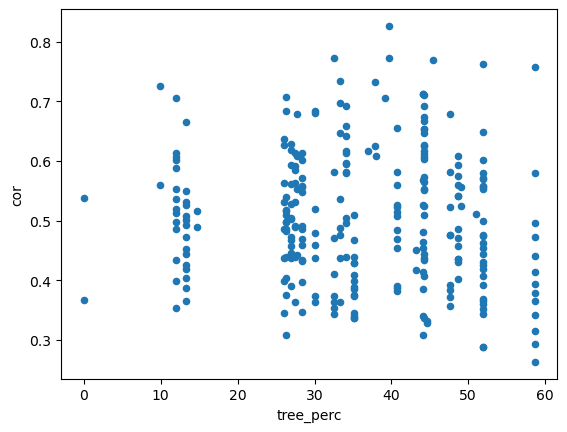

In [13]:
df[df.days < 8].plot.scatter(x = 'tree_perc', y = 'cor')